### Notebook for encounter (includes all navigation statuses):
- Used to generate other vessel data (includes all navigation status ; all sog (0-40) vessel )


In [1]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import figure
from matplotlib.colors import ListedColormap
from matplotlib import cm

from PIL import Image
import requests
import math
from scipy.interpolate import interp1d
import datetime
from datetime import datetime
import matplotlib.collections as colors

from math import radians, sin, cos, sqrt, atan2
from geopy.distance import geodesic
from geopy.distance import distance
from vincenty import vincenty
import haversine as hs
from geopy.distance import great_circle
from rtree import index
from shapely.geometry import Point, Polygon

# import cupy as cp # for hadling df on gpu 




#### Reading all vessel dataframe 

In [2]:
to_process_data_path = r'W:\Neeraj_thesis\version2_thesis\dataset\2019\generator_version_1_output\v1_ais_data_clean_600_12.csv'
to_store_data_path = r'W:\Neeraj_thesis\version2_thesis\dataset\2019\generator_version_6_output_uniform_ts\data_2019_12_v6_out_uniform_ts.csv'
path_for_min_time  = r'W:\Neeraj_thesis\version2_thesis\dataset\2019\generator_version_2_output_unifom_ts\data_2019_12_v2_uniform_ts_out.csv'
coast_points_path = r'W:\Neeraj_thesis\version2_thesis\dataset\coastline\oslo_fjord_coastline.csv'


In [3]:
ais_data_oslo_600 = pd.read_csv(to_process_data_path)

C:\Users\neerajm\AppData\Local\Temp\4\ipykernel_17160\3437660280.py:1: DtypeWarning: Columns (6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  ais_data_oslo_600 = pd.read_csv(to_process_data_path)


In [4]:
ais_data_oslo_600_v1 = ais_data_oslo_600.copy()   ### to to removed when filtering out navigation status.  

In [5]:
## DATA PROCESSINNG - 
# Max/Min Lat/Long: Lat ( ) ; Lon ( ) 
# Finding the sog_calc :
ais_data_oslo_600_v1 = ais_data_oslo_600_v1.loc[:, ['mmsi', 'unixtime(timestamp)', 'lat', 'lon', 'sog', 'cog', 'mmsi_voyage_num']].reset_index(drop=True)

# ### USE: IF SOG is common-string 
ais_data_oslo_600_v1['sog'] = ais_data_oslo_600_v1['sog'].str.replace(',','.').astype(float)
ais_data_oslo_600_v1['short_voyage_id'] = ais_data_oslo_600_v1.groupby('mmsi_voyage_num').ngroup()


In [6]:
ais_data_oslo_600_v1_with_cog = ais_data_oslo_600_v1.copy()
if ais_data_oslo_600_v1['cog'].str.contains(',').any():
    # Replace commas with dots
    ais_data_oslo_600_v1['cog'] = ais_data_oslo_600_v1['cog'].str.replace(',', '.')
    ais_data_oslo_600_v1['cog'] = pd.to_numeric(ais_data_oslo_600_v1['cog'], errors='coerce')
    ais_data_oslo_600_v1['cog'] = ais_data_oslo_600_v1['cog'].fillna(ais_data_oslo_600_v1_with_cog['cog'])



In [7]:
# Rounding features (latitude, longitude, sog, cog): 
ais_data_oslo_600_v1['lat'] = ais_data_oslo_600_v1['lat'].round(5)
ais_data_oslo_600_v1['lon'] = ais_data_oslo_600_v1['lon'].round(5)
ais_data_oslo_600_v1['sog'] = ais_data_oslo_600_v1['sog'].round(1)
ais_data_oslo_600_v1['cog'] = ais_data_oslo_600_v1['cog'].round(0)

In [8]:
## Creating a 1s frequency dataset. 
# Load the data
df = ais_data_oslo_600_v1.copy()

# Group the DataFrame by the mmsi_voyage_num column and create a dictionary of DataFrames
dfs = df.groupby('short_voyage_id')

results = []
count = 0

for num, df in dfs:
    count += 1
    print(count)
    df = df.sort_values('unixtime(timestamp)')
    df['datetime'] = pd.to_datetime(df['unixtime(timestamp)'], unit='s') # Convert the Unix timestamps to datetime objects and set the datetime column as the index
    df = df.drop_duplicates(subset='datetime')     # Drop duplicate rows based on the datetime column
    df = df.set_index('datetime')

    df = df.resample('1S').asfreq()  # Resample the DataFrame with a one-second frequency
    results.append(df)

df = pd.concat(results, axis=0) # Concatenate the results back into a single DataFrame

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [9]:
df = df.reset_index()
ais_data_oslo_600_v2 = df.copy()

In [10]:
# convert the datetime column to Unix timestamps
ais_data_oslo_600_v2['unixtime'] = ais_data_oslo_600_v2['datetime'].apply(lambda x: x.timestamp())
ais_data_oslo_600_v2 =  ais_data_oslo_600_v2.drop(['mmsi_voyage_num','datetime','unixtime(timestamp)'], axis=1).reset_index(drop = True)

In [11]:
ais_data_oslo_600_v3 = ais_data_oslo_600_v2.copy()

In [12]:
df = ais_data_oslo_600_v3.copy()

# define the Vincenty formula as a custom interpolation function
def vincenty(x1, x2, y1, y2):
    return distance((x1, y1), (x2, y2)).km

def interpolate_vincenty(col):
    return col.interpolate(method='linear', limit_direction='both', limit_area='inside', interp_func=vincenty)

df['lat'] = interpolate_vincenty(df['lat'])
df['lon'] = interpolate_vincenty(df['lon'])

In [13]:
# handling NaN values
df['short_voyage_id'] = df['short_voyage_id'].fillna(method='ffill')
ais_data_oslo_600_v4 = df.copy()
ais_data_oslo_600_v4['short_voyage_id'] = ais_data_oslo_600_v4['short_voyage_id'].astype(int)
ais_data_oslo_600_v4['unixtime'] = ais_data_oslo_600_v4['unixtime'].astype(int)
ais_data_oslo_600_v4['mmsi'] = ais_data_oslo_600_v4['mmsi'].fillna(method='ffill')
ais_data_oslo_600_v4['mmsi'] = ais_data_oslo_600_v4['mmsi'].astype(int)

In [14]:
ais_data_oslo_600_v5 = ais_data_oslo_600_v4.copy()
ais_data_oslo_600_v5['cog'] = ais_data_oslo_600_v5['cog'].interpolate() 

In [16]:
df_for_min_time = pd.read_csv(path_for_min_time)
min_time_value = df_for_min_time['unixtime'].min()
start_time_value = min_time_value
print(start_time_value)

ais_data_oslo_600_v6 = ais_data_oslo_600_v5[(ais_data_oslo_600_v5['unixtime'] - start_time_value) % 30 == 0]
ais_data_oslo_600_v6 = ais_data_oslo_600_v6.reset_index(drop=True)

print(ais_data_oslo_600_v6.head())


1575158460
   mmsi        lat       lon  sog         cog  short_voyage_id    unixtime
0     0  58.876845  9.416865  NaN  305.500000                0  1575639540
1     0  58.876840  9.416870  NaN  278.000000                0  1575639570
2     0  58.876791  9.416855  NaN  274.636364                0  1575639600
3     0  58.876790  9.416849  NaN  281.444444                0  1575639630
4     0  58.876794  9.416840  NaN  289.111111                0  1575639660


In [19]:
df_30_sec = ais_data_oslo_600_v6.copy() 

In [20]:
df_30_sec.isna().sum()

mmsi                     0
lat                      0
lon                      0
sog                8519476
cog                      0
short_voyage_id          0
unixtime                 0
dtype: int64

In [21]:

df_30_sec.sort_values(by=['short_voyage_id', 'unixtime'], inplace=True)


df_30_sec['lat_diff'] = df_30_sec.groupby('short_voyage_id')['lat'].diff().fillna(0)
df_30_sec['lon_diff'] = df_30_sec.groupby('short_voyage_id')['lon'].diff().fillna(0)


df_30_sec['distance'] = df_30_sec.apply(
    lambda row: hs.haversine((row['lat'], row['lon']), (row['lat'] - row['lat_diff'], row['lon'] - row['lon_diff']), unit= 'm'),
    axis=1
)

df_30_sec['time_diff'] = df_30_sec.groupby('short_voyage_id')['unixtime'].diff()

df_30_sec['sog'] = (df_30_sec['distance'] * 1.94384) / df_30_sec['time_diff']


In [22]:
ais_data_oslo_600_v6 = df_30_sec.copy()
ais_data_oslo_600_v6['sog'] = ais_data_oslo_600_v6['sog'].fillna(method='ffill')
ais_data_oslo_600_v6['sog'] = ais_data_oslo_600_v6['sog'].fillna(0)

In [23]:
ais_data_oslo_600_v7 = ais_data_oslo_600_v6.copy()

In [24]:
# define a function to remove the first and last values from a group
def remove_first_last(group):
    return group.iloc[1:-1]

# group the dataframe by 'short_voyage_id' and apply the function to each group
ais_data_oslo_600_v7 = ais_data_oslo_600_v7.groupby('short_voyage_id').apply(remove_first_last)
mmsi_to_remove = ais_data_oslo_600_v7[ais_data_oslo_600_v7['sog'] > 40]['mmsi'].unique()
ais_data_oslo_600_v7 = ais_data_oslo_600_v7[~ais_data_oslo_600_v7['mmsi'].isin(mmsi_to_remove)]

In [25]:
ais_data_oslo_600_v7 = ais_data_oslo_600_v7.reset_index(drop = True)
ais_data_oslo_600_v8 = ais_data_oslo_600_v7.copy()

In [26]:
ais_data_oslo_600_v8['cog'] = ais_data_oslo_600_v8['cog'].apply(lambda x: math.floor(x))
ais_data_oslo_600_v8['sog'] = ais_data_oslo_600_v8['sog'].apply(lambda x: round(x,2))
ais_data_oslo_600_v8 = ais_data_oslo_600_v8.drop(['lat_diff', 'lon_diff', 'distance', 'time_diff'], axis=1)


In [27]:
ais_data_oslo_600_v9 = ais_data_oslo_600_v8.copy()
ais_data_oslo_600_v9['sog'] = ais_data_oslo_600_v9['sog'].apply(lambda x: math.floor(x))

In [28]:
## For data exploratoin (visualization)
zero_sog_percent_data = (ais_data_oslo_600_v9.groupby('mmsi')['sog'].apply(lambda x: ((x == 0)).mean())*100).rename('percent_zero_sog')
zero_or_one_sog_percent_data = (ais_data_oslo_600_v9.groupby('mmsi')['sog'].apply(lambda x: ((x == 0) | (x == 1)).mean())*100).rename('percent_zero_one_sog')
zero_one_two_sog_percent_data = (ais_data_oslo_600_v9.groupby('mmsi')['sog'].apply(lambda x: ((x == 0) | (x == 1) | (x == 2)).mean())*100).rename('percent_zero_one_two_sog')
zero_sog_percent_data_df = zero_sog_percent_data.to_frame().round()
zero_or_one_sog_percent_df = zero_or_one_sog_percent_data.to_frame().round()
zero_one_two_sog_percent_df = zero_one_two_sog_percent_data.to_frame().round()


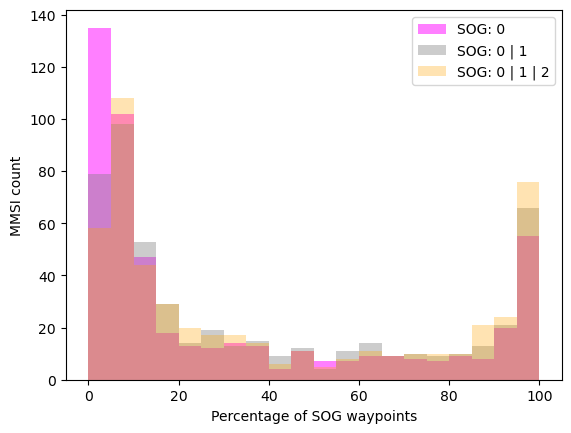

In [29]:
## For data exploratoin (visualization)
color1 = 'magenta'
color2 = 'gray'
color3 = 'orange'
plt.hist(zero_sog_percent_data_df['percent_zero_sog'], bins=20, alpha = 0.5 , color = color1, label = "SOG: 0")
plt.hist(zero_or_one_sog_percent_df['percent_zero_one_sog'], bins=20 , alpha = 0.4, color = color2 , label = "SOG: 0 | 1")
plt.hist(zero_one_two_sog_percent_df['percent_zero_one_two_sog'], bins=20, alpha = 0.3, color = color3 , label = "SOG: 0 | 1 | 2")
plt.xlabel('Percentage of SOG waypoints')
plt.ylabel('MMSI count')
plt.legend()
plt.show()

In [30]:
ais_data_oslo_600_v10 = ais_data_oslo_600_v9.copy()

#### Adding features of Nearest distance to coast and TSS (In_TSS)

In [31]:
coast_points = pd.read_csv(coast_points_path)
coast_points =  coast_points.drop(['Unnamed: 0'], axis=1).reset_index(drop = True)

In [32]:
def create_coast_index(coast_df):
    idx = index.Index()
    for i, row in coast_df.iterrows():
        lat, lon = row['lat'], row['lon']
        idx.insert(i, (lon, lat, lon, lat))

    return idx

def nearest_distance_to_coast_rtree(lat, lon, coast_df, coast_index):
    vessel_point = (lat, lon)
    min_distance = float('inf')
    for coast_idx in coast_index.nearest((lon, lat, lon, lat)):
        coast_point = (coast_df.at[coast_idx, 'lat'], coast_df.at[coast_idx, 'lon'])
        distance = great_circle(vessel_point, coast_point).meters

        if distance < min_distance:
            min_distance = distance
    return min_distance
coast_index = create_coast_index(coast_points)
ais_data_oslo_600_v10['NDC_m'] = ais_data_oslo_600_v10.apply(lambda row: nearest_distance_to_coast_rtree(row['lat'], row['lon'], coast_points, coast_index), axis=1)


In [34]:
ais_data_oslo_600_v11 = ais_data_oslo_600_v10.copy()

In [35]:
ais_data_oslo_600_v11 =  ais_data_oslo_600_v11.drop(['NDC_m'], axis=1).reset_index(drop = True)

In [36]:
# Moving out
# # Outer to inner: 
# lat_1,lon_1 = 59.15952, 10.630281
# lat_2, lon_2 = 59.434427, 10.538721
# lat_3, lon_3 = 59.514555, 10.565243
# lat_4, lon_4 = 59.562723, 10.609274

# # Moving in 
# # Inner to outer:
# lat_5, lon_5 = 59.562767, 10.648413
# lat_6, lon_6 = 59.558244, 10.647554 
# lat_7, lon_7 = 59.514468, 10.60009
# lat_8, lon_8 = 59.434471, 10.567045
# lat_9, lon_9 = 59.162864, 10.668755


## With margin:
lat_1,lon_1 = 59.158112, 10.619316
lat_2, lon_2 = 59.322287, 10.550737

lat_3, lon_3 = 59.334021, 10.541897
lat_4, lon_4 = 59.363426, 10.548849
lat_5, lon_5 = 59.427574, 10.528078
lat_6, lon_6 = 59.435038, 10.520954 

lat_7, lon_7 = 59.509373, 10.553484
lat_8, lon_8 = 59.514468, 10.562239
lat_9, lon_9 = 59.521304, 10.560436
lat_10, lon_10 = 59.550111, 10.586185

lat_11,lon_11 = 59.562202, 10.605755


# Moving in 
# Inner to outer:
lat_12,lon_12 = 59.56281, 10.64867
lat_13,lon_13 = 59.555548, 10.649958
lat_14,lon_14 = 59.548023, 10.647039
lat_15,lon_15 = 59.514032, 10.611248
lat_16,lon_16 = 59.438748, 10.582409
lat_17,lon_17 = 59.434732, 10.575714
lat_18,lon_18 = 59.164624, 10.68532



In [38]:

# Define the polygon vertices as a list of (latitude, longitude) pairs
polygon_vertices = [(lat_1, lon_1), (lat_2, lon_2), (lat_3, lon_3),(lat_4, lon_4), (lat_5, lon_5), (lat_6, lon_6),(lat_7, lon_7), (lat_8, lon_8), (lat_9, lon_9), (lat_10, lon_10), (lat_11, lon_11), (lat_12, lon_12), (lat_13, lon_13), (lat_14, lon_14), (lat_15, lon_15), (lat_16, lon_16), (lat_17, lon_17), (lat_18, lon_18)]

# Create a Shapely Polygon object from the vertices
polygon = Polygon(polygon_vertices)
for_tss_group = ais_data_oslo_600_v11.groupby('short_voyage_id')
sub_dfs = []
count = 0
in_tss = 1 # initialize the new_short_voyage_id
not_in_tss = 0

for id, data_frame in for_tss_group:
    count += 1
    print(count)
    data_frame = data_frame.reset_index(drop=True)
    sub_dfs_temp = []
    start_index = 0

    for index, row in data_frame.iterrows():
        lat, lon = row['lat'], row['lon']
        # Define a point to test (latitude, longitude)
        point = Point(lat, lon)
        if polygon.contains(point):
            data_frame.at[index, 'In_TSS'] = 1
        else:
            data_frame.at[index, 'In_TSS'] = 0
    sub_dfs_temp.append(data_frame)
    sub_dfs += sub_dfs_temp

# concatenate all the sub-DataFrames into a single DataFrame
ais_data_oslo_600_v11 = pd.concat(sub_dfs, ignore_index=True)




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


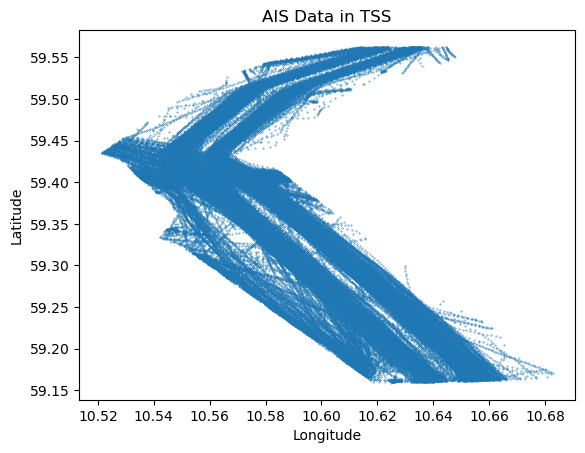

In [39]:
## For data exploratoin (visualization)
import matplotlib.pyplot as plt

# filter the AIS data where In_TSS is 1
ais_in_tss = ais_data_oslo_600_v11[ais_data_oslo_600_v11['In_TSS'] == 1]

plt.scatter(ais_in_tss['lon'], ais_in_tss['lat'], s=0.1)
plt.title('AIS Data in TSS')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [40]:
#### Vessel belong to TSS TRANSIT if number of timesteps in TSS > 10 minutes
ais_data_oslo_600_v12 = ais_data_oslo_600_v11.copy()
# ## entry
# lat_low = 59.175225 # lon = 10.64395
# ## exit
# lat_high = 59.619853 # lon = 10.626526
## entry and exit with margin:
lat_low = 59.19712 # , 10.63674
lat_high = 59.548589# , 10.61451
## breadth of TSS: lat/lon left: 59.434471/ 10.538549 ; lat/lon right: 59.434514/ 10.566788
# Load the data
voy_group_data = ais_data_oslo_600_v12.groupby('short_voyage_id')
voy_dfs = []
count = 0
for id, voy_df in voy_group_data:
    count += 1
    print(count)
    
    # check if all In_TSS values are 1 for latitude in range (x, y)
    if (voy_df['lat'].min() < lat_low) & (voy_df['lat'].max() > lat_high):
        if voy_df[(voy_df['lat'] >= lat_low) & (voy_df['lat'] <= lat_high)]['In_TSS'].all() == 1:
            voy_df.loc[:, 'Vessel_TSS'] = 1
        else:
            pass
        
    else:
        voy_df.loc[:,'Vessel_TSS'] = 0
    # Append the modified group dataframe to the list
    voy_dfs.append(voy_df)
# Concatenate the individual group dataframes into one net dataframe
ais_data_oslo_600_v12 = pd.concat(voy_dfs)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [41]:
# Filter the dataframe to include only voyages where Vessel_TSS is 1
tss_voyages = ais_data_oslo_600_v12[ais_data_oslo_600_v12['Vessel_TSS'] == 1]

# Count the number of unique short voyage IDs in the filtered dataframe
num_tss_voyages = tss_voyages['short_voyage_id'].nunique()

print("Number of unique short voyage IDs with Vessel_TSS as 1:", num_tss_voyages)


Number of unique short voyage IDs with Vessel_TSS as 1: 366


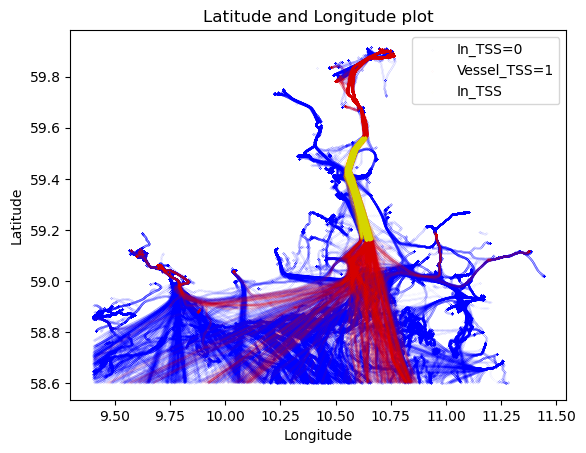

In [42]:
## For data exploratoin (visualization)

# Get the indices where In_TSS is 0 or 1
idx_0 = ais_data_oslo_600_v12['Vessel_TSS'] == 0
idx_1 = ais_data_oslo_600_v12['Vessel_TSS'] == 1
# idx_2 = ais_clean_v5['In_TSS'] == 1
idx_2 = (ais_data_oslo_600_v12['In_TSS'] == 1) & (ais_data_oslo_600_v12['Vessel_TSS'] == 1)
plt.scatter(ais_data_oslo_600_v12['lon'][idx_0], ais_data_oslo_600_v12['lat'][idx_0], color='blue', label='In_TSS=0', s = 0.0002)
plt.scatter(ais_data_oslo_600_v12['lon'][idx_1], ais_data_oslo_600_v12['lat'][idx_1], color='red', label='Vessel_TSS=1', s = 0.0002)
plt.scatter(ais_data_oslo_600_v12['lon'][idx_2], ais_data_oslo_600_v12['lat'][idx_2], color='yellow', label='In_TSS', s = 0.0002)

plt.title('Latitude and Longitude plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.legend()

plt.show()


In [43]:
ais_data_oslo_600_v12.to_csv(to_store_data_path, index=False)